<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [9]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function should append to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function should also handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [10]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(eta = 0.7, max_depth= 19, subsample = 0.7, verbosity = 0) 

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)
    
    return xgb, ttimes


In [11]:
def train_classifier_DNN(X_train, y_train): 
    size = (10,) * 3
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='logistic',
                                solver='adam', learning_rate='invscaling', max_iter=1000)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)
    
    return dnn, ttimes


In [12]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=21, p=2, n_neighbors=4)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)
    
    return knn, ttimes

In [13]:
################################################################################################################
###### Split (X,y) obtained in task 3b (they had window length=10 and spacing=1) into train/test ######
###### sets (80%/20%). Then, call functions train_classifier_XGB() and train_classifier_DNN(). ########
###### Save trained models (returned by the three functions) into .json files. ########################
################################################################################################################'

lbl = [0, 1]

def training_alg(name, X_train, y_train, X_test, y_test):
    
    model, ttimes = None, []
    
    print(f'Training {name} 3 times...')
    if name == 'XGB':
        model, ttimes = train_classifier_XGB(X_train, y_train)
    elif name == 'MLP':
        model, ttimes = train_classifier_DNN(X_train, y_train)
    elif name == 'KNN':
        model, ttimes = train_classifier_KNN(X_train, y_train)
        
    # Added to fix: 'XGBClassifier' object has no attribute '_le'
    if (isinstance(model, XGBClassifier)):
        model._le = LabelEncoder().fit(y_test)
            
    y_pred = model.predict(X_test)
    
    accuracy = mt.accuracy_score(y_test, y_pred)
    global_precision = mt.precision_score(y_test, y_pred, labels=lbl, average='weighted')
    global_recall = mt.recall_score(y_test, y_pred, labels=lbl, average='weighted')
    global_f1score = mt.f1_score(y_test, y_pred, labels=lbl, average='weighted')
    
    y_score = model.predict_proba(X_test)[:, 1]
    
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test,  y_score)
    auc = roc_auc_score(y_test, y_score)
    
    stats = [ttimes, recall_curve, precision_curve, fpr, tpr, auc, accuracy, global_precision, global_recall, global_f1score]
    return stats

def training(X, y):
    # Stratify garantees the split all the scenarios among train and test
    # It's like shuffle and split
    # random_state it's a seed to get the same output
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    print(y_test)
    print(X_test)
    
    xgb_stats = training_alg('XGB', X_train, y_train, X_test, y_test)
    dnn_stats = training_alg('MLP', X_train, y_train, X_test, y_test)
    knn_stats = training_alg('KNN', X_train, y_train, X_test, y_test)
    
    return xgb_stats, dnn_stats, knn_stats


In [17]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None

#All scenario correlated ONLY TO "length=10" and "spacing=1"
length=10
spacing=1
folderpath='../Features'

for filename in os.listdir(folderpath):
    #F: you should continue iterating over "Features" folder looking for the desired files    
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))


X_stand = StandardScaler().fit_transform(X)
X_norm = MinMaxScaler().fit_transform(X)

xgb_stats_untouched, dnn_stats_untouched, knn_stats_untouched = training(X, y)
xgb_stats_stand, dnn_stats_stand, knn_stats_stand = training(X_stand, y)
xgb_stats_norm, dnn_stats_norm, knn_stats_norm = training(X_norm, y)

Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [29]:
def plot_roc_curve(fig_folder, alg_name, fpr, tpr, auc, data_type):
    #create ROC curve
    fig, ax = plt.subplots()
    ax.plot(fpr,tpr, color='purple',label="AUC="+str(auc))
    image_title =alg_name+' ROC Curve'
    if data_type == 1:
        image_title = image_title + ' Standardized'
    elif data_type == 2:
        image_title = image_title + ' Normalized'
    elif data_type == 3:
         image_title = image_title + ' Untouched'
    ax.set_title(image_title)
    ax.legend(loc=4)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')
    plt.show()
    
def plot_precision_recall_curve(fig_folder, alg_name, recall_curve, precision_curve, data_type):
    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall_curve, precision_curve, color='purple')
    image_title =alg_name+' Precision-Recall Curve'
    if data_type == 1:
        image_title = image_title + ' Standardized'
    elif data_type == 2:
        image_title = image_title + ' Normalized'
    elif data_type == 3:
         image_title = image_title + ' Untouched'
    #add axis labels to plot
    ax.set_title(image_title)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')
    plt.show()

    
def bar_chart_stand_norm_impact(fig_folder, alg_name, labels, stats_stand, stats_norm, stats_untouched):
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    r1 = np.arange(len(stats_stand))
    r2 = [x + width for x in r1]
    r3 = [x + width for x in r2]

    fig, ax = plt.subplots(figsize=(15,8))
    rects1 = ax.bar(r1, stats_stand, width, label='Standardized')
    rects2 = ax.bar(r2, stats_norm, width, label='Normalized')
    rects3 = ax.bar(r3, stats_untouched, width, label='Untouched')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    image_title = alg_name+' Stand and Norm Impact on metrics'
    ax.set_title(image_title)
    ax.set_xticks([r + width for r in range(len(stats_stand))], labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

    ax.bar_label(rects1, label_type='center', padding=3, rotation=45)
    ax.bar_label(rects2, label_type='center', padding=3, rotation=45)
    ax.bar_label(rects3, label_type='center', padding=3, rotation=45)
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')
    plt.show()


def candle_norm_stand_impact(fig_folder, alg_name, stats_stand, stats_norm, stats_untouched):
    labels = ['Standardized', 'Normalized', 'Untouched']
    all_data = [stats_stand, stats_norm, stats_untouched]
    fig, ax = plt.subplots(figsize=(15,8))
    
    bplot = ax.boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
    image_title=alg_name+' Stand and Norm Impact on Traning Time'
    ax.set_title(image_title)

    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax.yaxis.grid(True)
    ax.set_ylabel('Seconds')
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')
    plt.show()

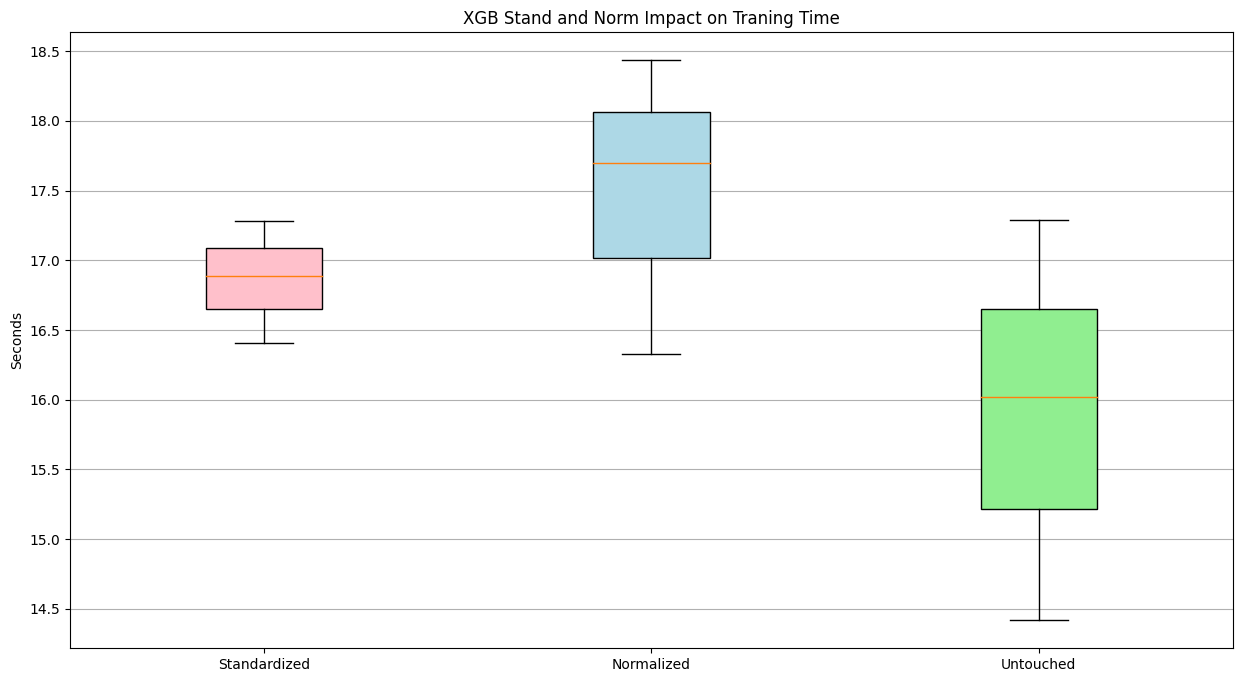

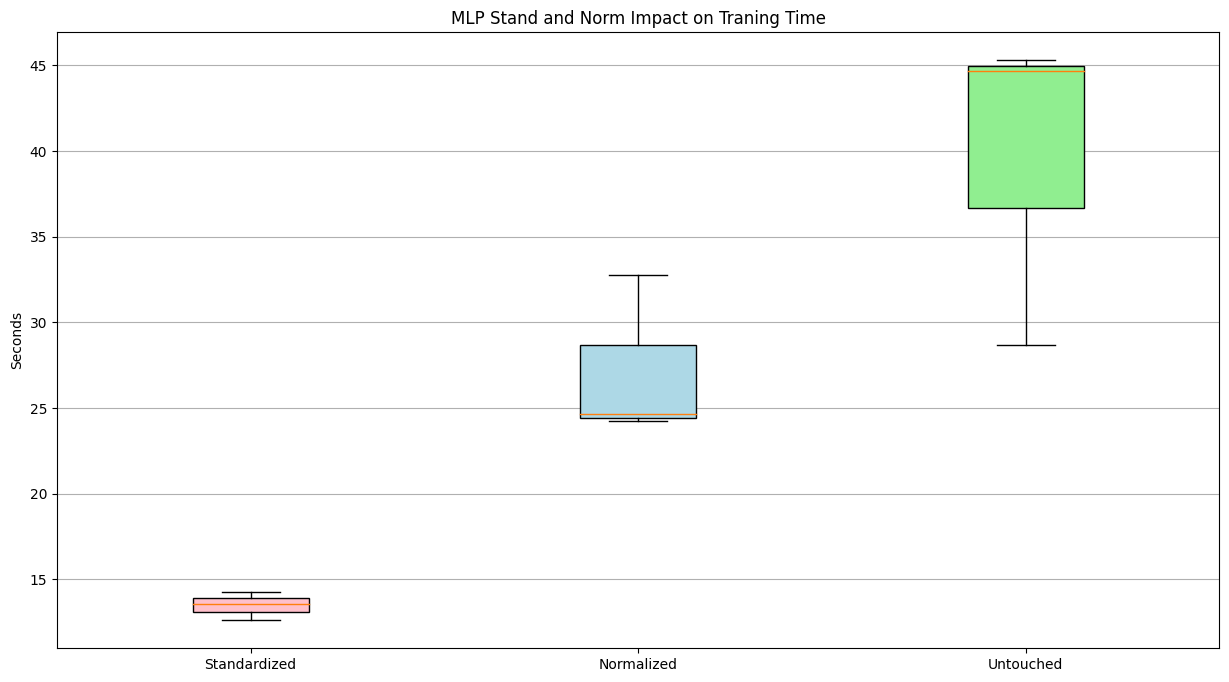

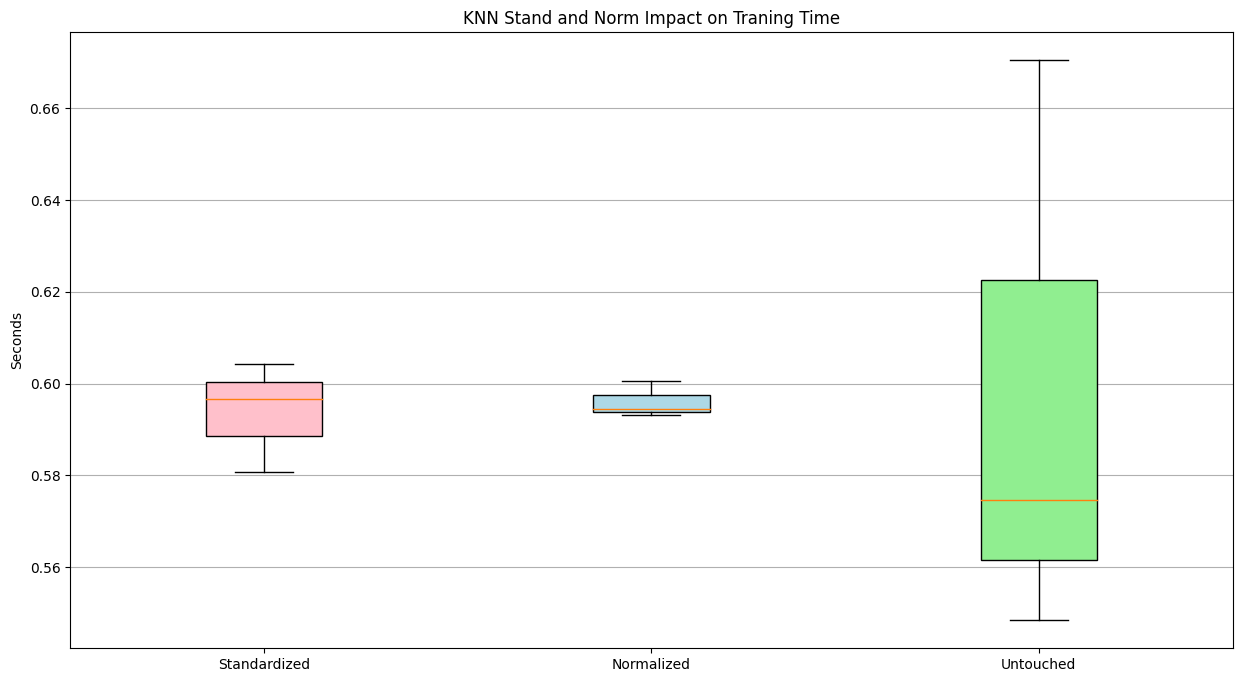

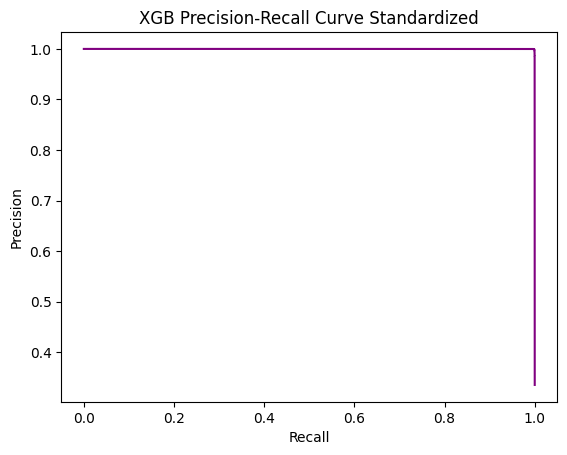

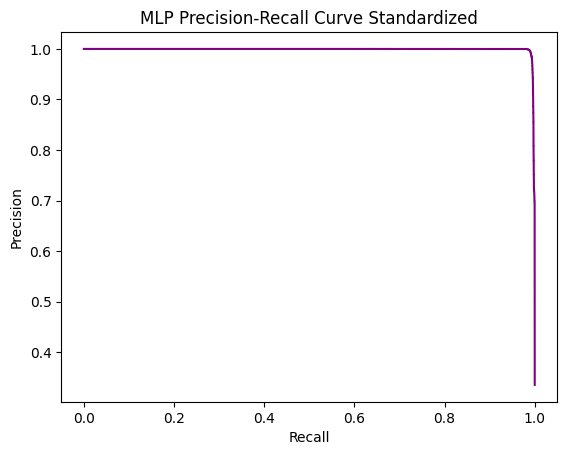

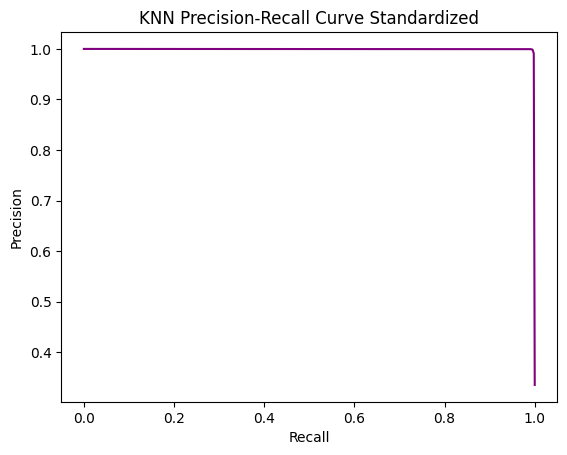

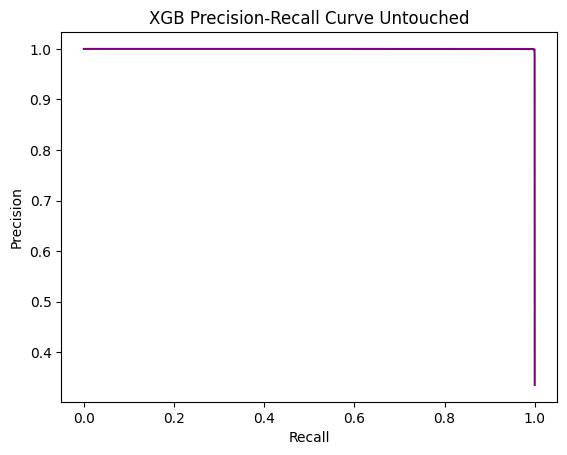

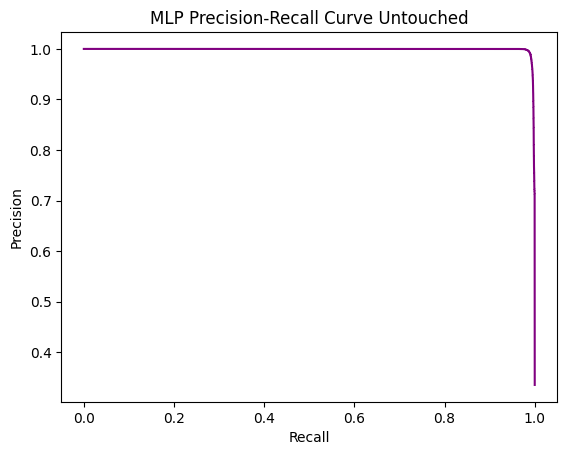

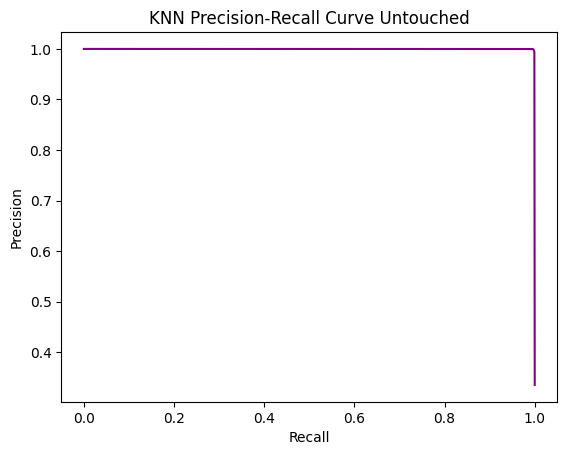

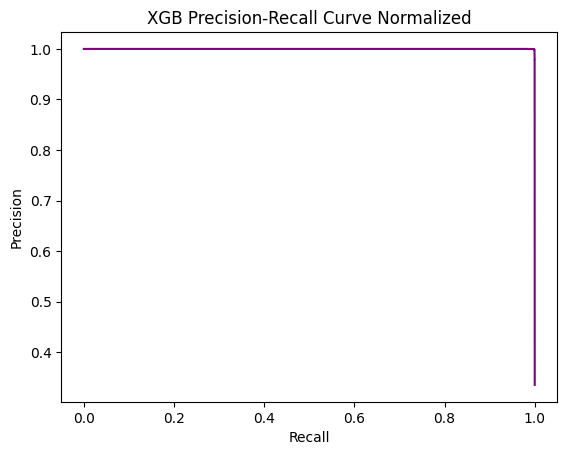

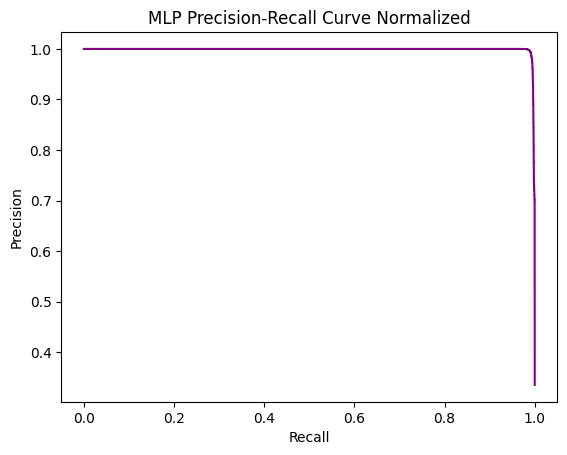

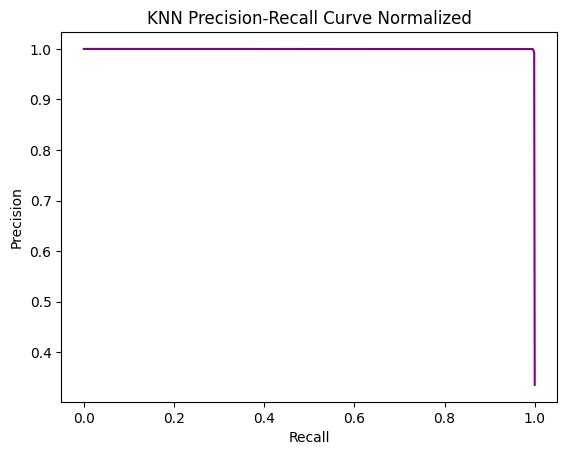

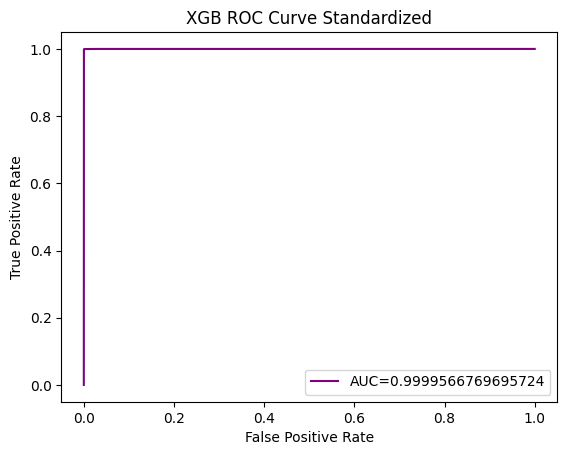

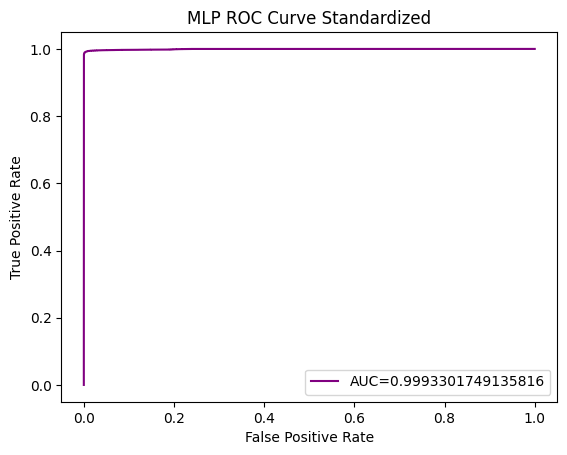

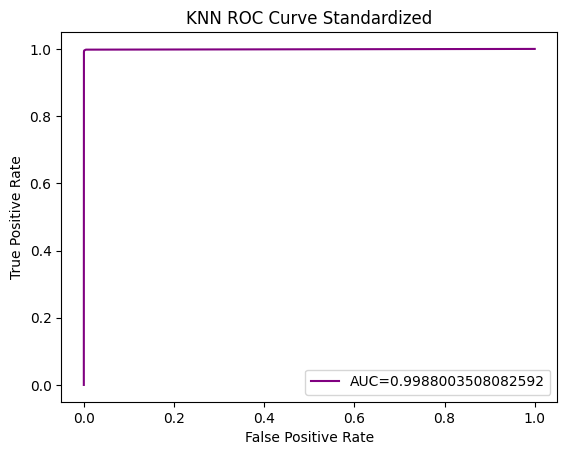

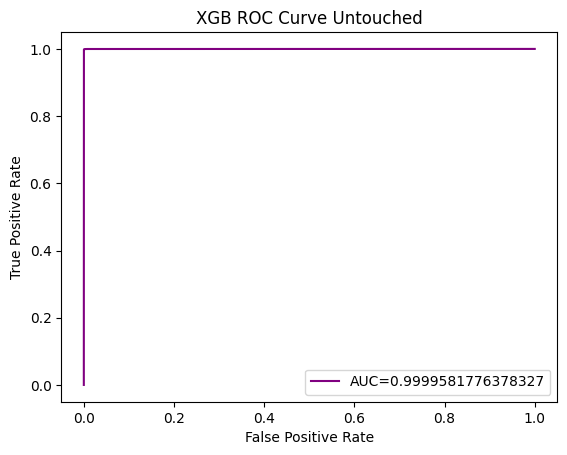

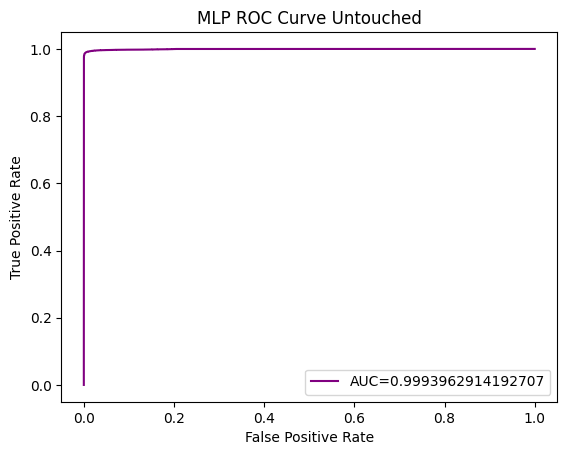

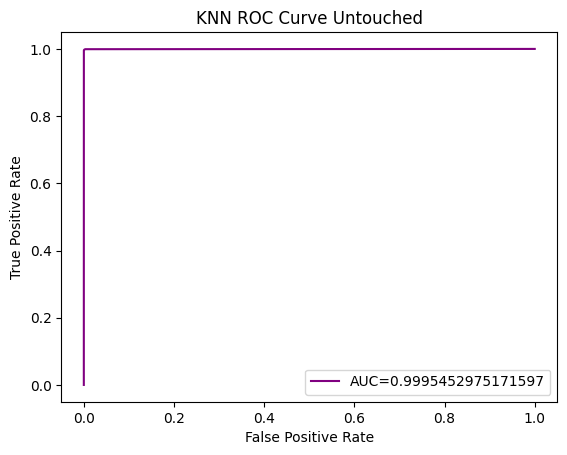

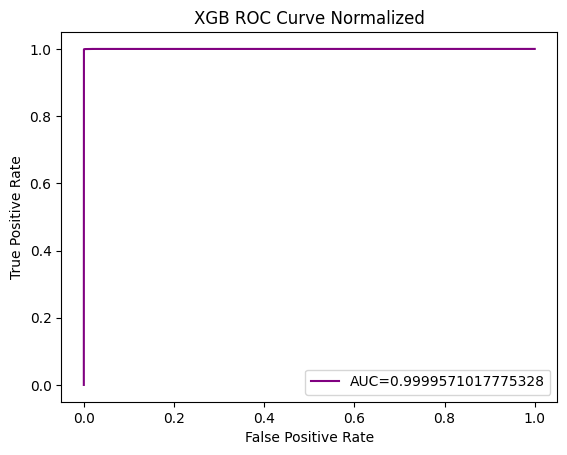

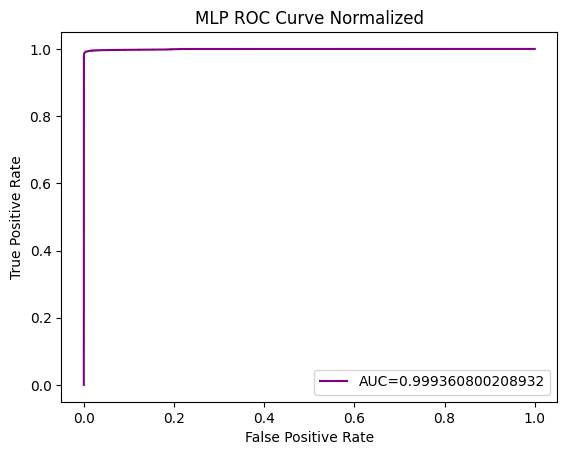

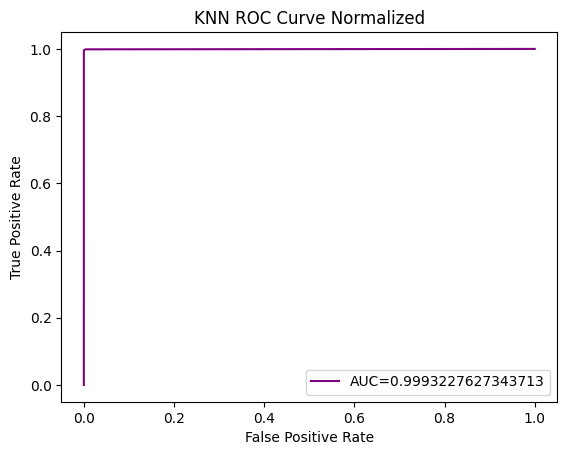

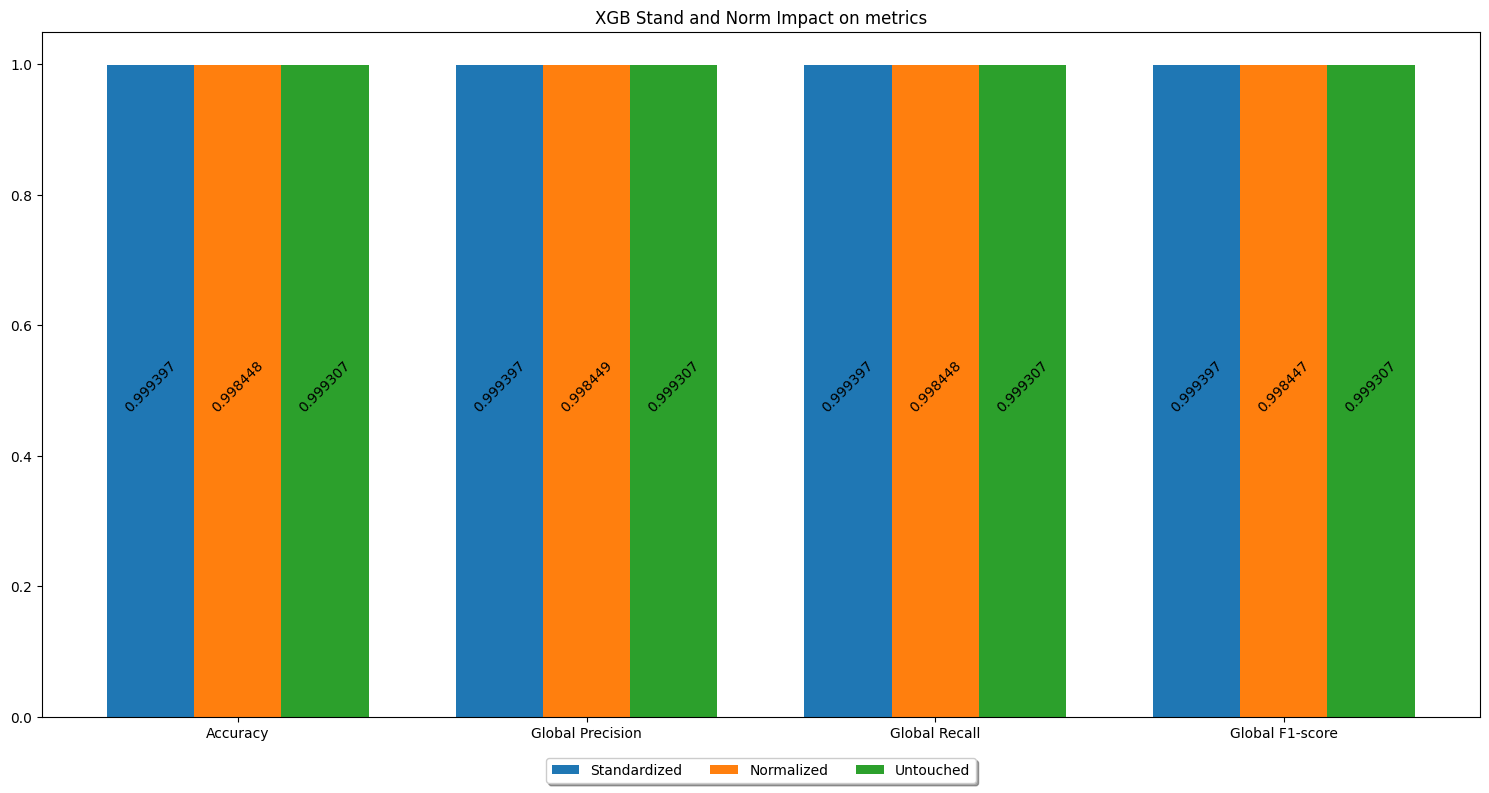

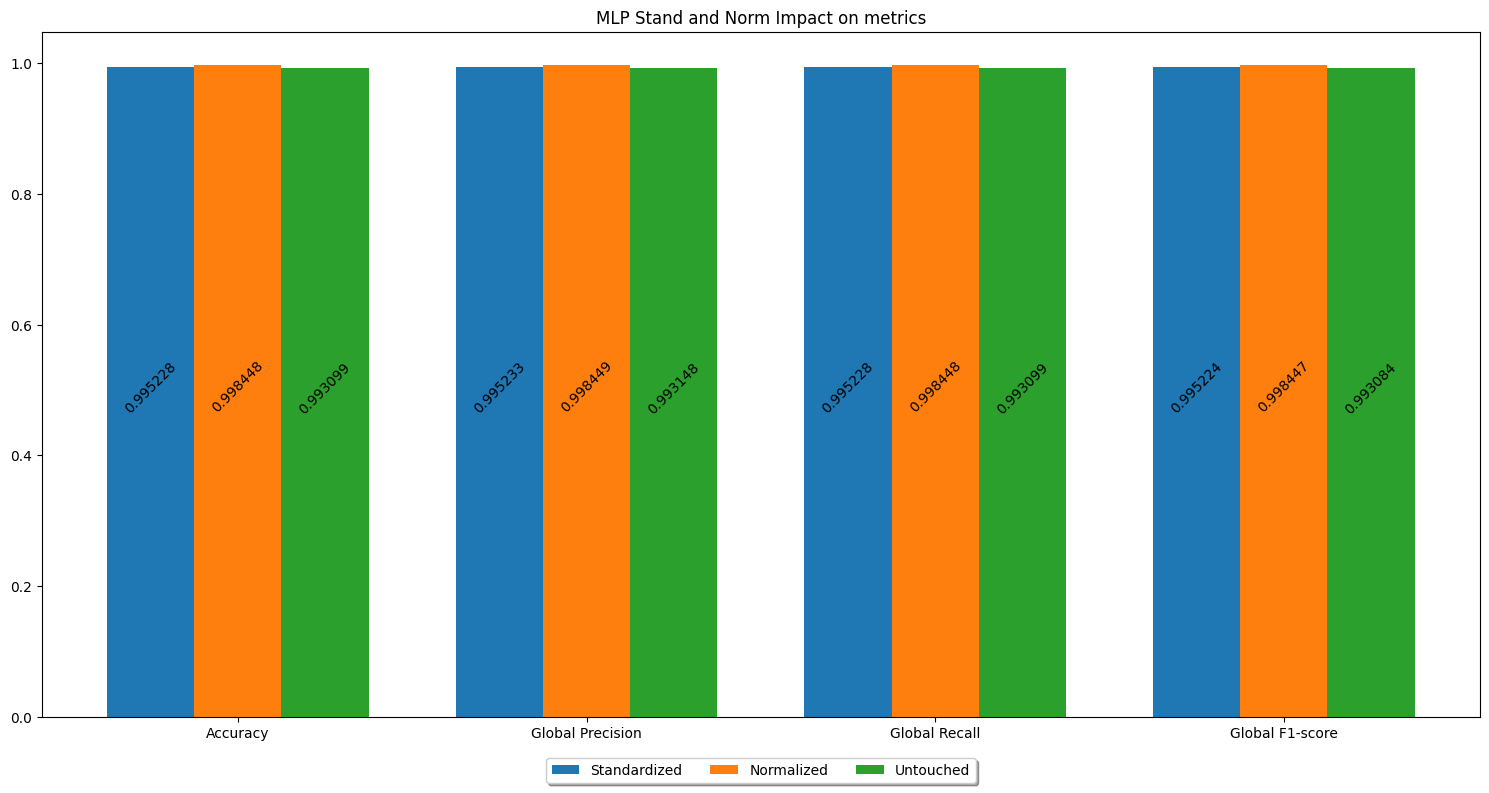

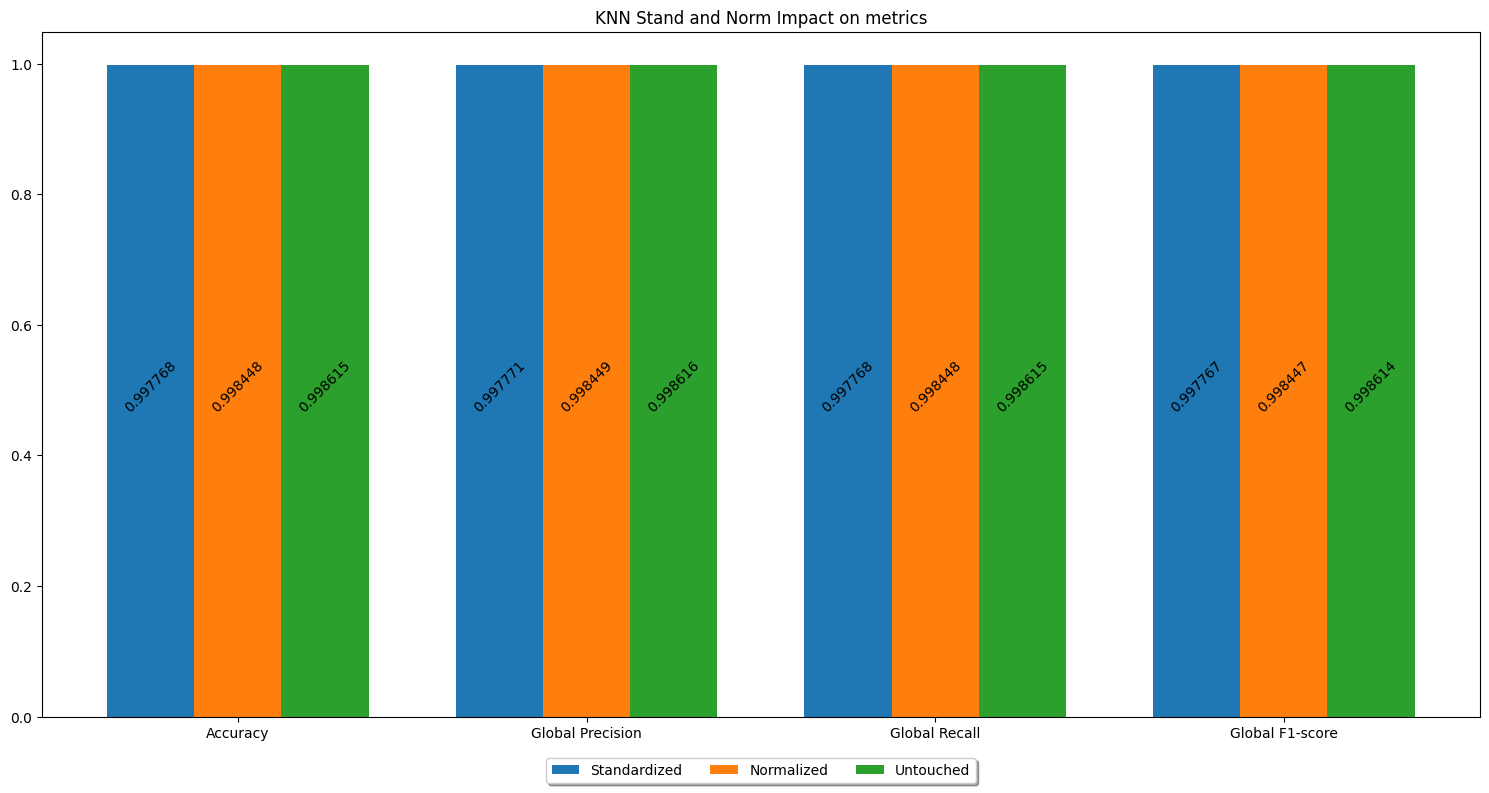

In [30]:
fig_folder = '1_2c_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
        
# Candles for 'Traning Time'
candle_norm_stand_impact(fig_folder, 'XGB', xgb_stats_stand[0], xgb_stats_norm[0], xgb_stats_untouched[0])    
candle_norm_stand_impact(fig_folder, 'MLP', dnn_stats_stand[0], dnn_stats_norm[0], dnn_stats_untouched[0])
candle_norm_stand_impact(fig_folder, 'KNN', knn_stats_stand[0], knn_stats_norm[0], knn_stats_untouched[0])

# PR curve
plot_precision_recall_curve(fig_folder, 'XGB', xgb_stats_stand[1], xgb_stats_stand[2], 1)
plot_precision_recall_curve(fig_folder, 'MLP', dnn_stats_stand[1], dnn_stats_stand[2], 1)
plot_precision_recall_curve(fig_folder, 'KNN', knn_stats_stand[1], knn_stats_stand[2], 1)

plot_precision_recall_curve(fig_folder, 'XGB', xgb_stats_untouched[1], xgb_stats_untouched[2], 3)
plot_precision_recall_curve(fig_folder, 'MLP', dnn_stats_untouched[1], dnn_stats_untouched[2], 3)
plot_precision_recall_curve(fig_folder, 'KNN', knn_stats_untouched[1], knn_stats_untouched[2], 3)

plot_precision_recall_curve(fig_folder, 'XGB', xgb_stats_norm[1], xgb_stats_norm[2], 2)
plot_precision_recall_curve(fig_folder, 'MLP', dnn_stats_norm[1], dnn_stats_norm[2], 2)
plot_precision_recall_curve(fig_folder, 'KNN', knn_stats_norm[1], knn_stats_norm[2], 2)

# ROC curve
plot_roc_curve(fig_folder, 'XGB', xgb_stats_stand[3], xgb_stats_stand[4], xgb_stats_stand[5], 1)
plot_roc_curve(fig_folder, 'MLP', dnn_stats_stand[3], dnn_stats_stand[4], dnn_stats_stand[5], 1)
plot_roc_curve(fig_folder, 'KNN', knn_stats_stand[3], knn_stats_stand[4], knn_stats_stand[5], 1)

plot_roc_curve(fig_folder, 'XGB', xgb_stats_untouched[3], xgb_stats_untouched[4], xgb_stats_untouched[5], 3)
plot_roc_curve(fig_folder, 'MLP', dnn_stats_untouched[3], dnn_stats_untouched[4], dnn_stats_untouched[5], 3)
plot_roc_curve(fig_folder, 'KNN', knn_stats_untouched[3], knn_stats_untouched[4], knn_stats_untouched[5], 3)

plot_roc_curve(fig_folder, 'XGB', xgb_stats_norm[3], xgb_stats_norm[4], xgb_stats_norm[5], 2)
plot_roc_curve(fig_folder, 'MLP', dnn_stats_norm[3], dnn_stats_norm[4], dnn_stats_norm[5], 2)
plot_roc_curve(fig_folder, 'KNN', knn_stats_norm[3], knn_stats_norm[4], knn_stats_norm[5], 2)

# Stats charts
stats_labels= ['Accuracy', 'Global Precision', 'Global Recall', 'Global F1-score']
bar_chart_stand_norm_impact(fig_folder, 'XGB', stats_labels, xgb_stats_stand[6:], knn_stats_norm[6:], xgb_stats_untouched[6:])    
bar_chart_stand_norm_impact(fig_folder, 'MLP', stats_labels, dnn_stats_stand[6:], knn_stats_norm[6:], dnn_stats_untouched[6:])
bar_chart_stand_norm_impact(fig_folder, 'KNN', stats_labels, knn_stats_stand[6:], knn_stats_norm[6:], knn_stats_untouched[6:])
